## Code Demonstration for Paper Presentation
Austin Coursey - Spring 2023
 Modification of TabularEvalSimple.ipynb from https://github.com/automl/TransformersCanDoBayesianInference/blob/master/requirements.txt
- Assumes you have cloned their repository and installed their requirements.
- This notebook should then be inside the "notebooks" folder
- Also use Python=3.9.0 and change their requirements.txt to allow gpytorch==1.6.0

In [2]:
import sys
sys.path.insert(0,'..')

In [33]:
import torch
import os

from train import train
import priors
import utils

import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification
from tabular import evaluate, get_model, get_default_spec, evaluate_dataset
from tabular import bayes_net_metric, gp_metric, knn_metric, catboost_metric, xgb_metric, logistic_metric
import matplotlib.pyplot as plt

In [6]:
%load_ext autoreload

%autoreload 2

## Loading Datasets

In [7]:
### Loads small list of datasets
print('Loading test datasets...')
test_datasets, test_datasets_df = load_openml_list(test_dids_classification[0:2], filter_for_nan=True)
ds = test_datasets

print('\n Loading valid datasets...')
valid_datasets, valid_datasets_df = load_openml_list(valid_dids_classification[0:2], filter_for_nan=True)

Loading test datasets...
wine 973
covertype 1596

 Loading valid datasets...
ionosphere 59


## Setting params

In [8]:
device = 'cpu'

In [9]:
# After how many training samples should evaluatuion be done?
# Trained models have not been trained to evaluate after 30 samples
# so performance will drop
eval_positions = [30]

# What is the maximum number of features?
# Pretrained models have to use 60
max_features = 60

# How many samples should be loaded for one dataset?
# Samples after the training sequence are used for evaluation
seq_len = 100

# How many subsamples of datasets should be drawn for each dataset
max_samples = 20

In [10]:
gp_model_checkpoint_dir = "../results/tabular_model_gp.ckpt"
gp_model_config = {'batch_size': 512,
 'bptt': 100,
 'dropout': 0.5,
 'emsize': 512,
 'epochs': 100,
 'eval_positions': [10, 20, 40, 80],
 'lr': 6.271726842985807e-05,
 'nhead': 4,
 'nhid_factor': 2,
 'nlayers': 5,
 'num_features': 60,
 'prior_lengthscale': 0.00014803074521613278,
 'prior_noise': 0.001,
 'prior_normalize_by_used_features': True,
 'prior_num_features_used_sampler': {'uniform_int_sampler_f(1,max_features)': '<function <lambda>.<locals>.<lambda> at 0x7f21e832e550>'},
 'prior_order_y': False,
 'prior_outputscale': 2.3163584733185836,
 'prior_type': 'gp'}

In [11]:
bnn_model_checkpoint_dir = "../results/tabular_model_bnn.ckpt"
bnn_model_config = {'batch_size': 512,
 'bptt': 50,
 'dropout': 0.5,
 'emsize': 512,
 'epochs': 100,
 'eval_positions': [10, 20, 40],
 'lr': 1.6421403128751275e-05,
 'nhead': 4,
 'nhid_factor': 2,
 'nlayers': 5,
 'num_features': 60,
 'prior_activations': "<class 'torch.nn.modules.activation.Tanh'>",
 'prior_dropout_sampler': {'lambda: 0.0': '<function <lambda> at 0x7f613c1364c0>'},
 'prior_emsize_sampler': {'scaled_beta_sampler_f(2.0, 4.0, 150, 2)': '<function <lambda>.<locals>.<lambda> at 0x7f613c136310>'},
 'prior_is_causal': False,
 'prior_nlayers_sampler': {'lambda: 3': '<function <lambda> at 0x7f613c136790>'},
 'prior_noise_std_gamma_k': 1.8663049257557085,
 'prior_noise_std_gamma_theta': 0.05275478076173361,
 'prior_normalize_by_used_features': False,
 'prior_num_features_used_sampler': {'scaled_beta_sampler_f(1.0, 1.6, max_features, 2)': '<function <lambda>.<locals>.<lambda> at 0x7f613c136550>'},
 'prior_order_y': True,
 'prior_sigma_gamma_k': 3.6187797729244253,
 'prior_sigma_gamma_theta': 0.06773738681062867,
 'prior_type': 'mlp'}

## Loading PFN

In [12]:
model_type = 'bnn'
if model_type == 'gp':
    raise Exception("Not Implemented")
    config = gp_model_config
    checkpoint_dir = gp_model_checkpoint_dir
elif model_type == 'bnn':
    config = bnn_model_config
    checkpoint_dir = bnn_model_checkpoint_dir

model = get_model(config, device, eval_positions, should_train=False)
model_state, _ = torch.load(checkpoint_dir)
model[2].load_state_dict(model_state)
model = model[2]

Using cpu:0 device
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 512, 'seq_len': 50, 'num_features': 60, 'hyperparameters': ('<function <lambda> at 0x7f613c136790>', '<function <lambda>.<locals>.<lambda> at 0x7f613c136310>', "<class 'torch.nn.modules.activation.Tanh'>", <function <lambda>.<locals>.<lambda> at 0x0000025B5CD2E5E0>, <function <lambda>.<locals>.<lambda> at 0x0000025B5CD2EE50>, '<function <lambda> at 0x7f613c1364c0>', True, '<function <lambda>.<locals>.<lambda> at 0x7f613c136550>', None, False, None, None, None, True, False, None, 0.0), 'batch_size_per_gp_sample': 8}, 'num_features': 60, 'num_outputs': 1}


Note that they are using the prior over Bayesian Neural Network architectures

### Visualizing Transformer Architecture

In [187]:
model

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): 

## Evaluation of PFN

### Transformer

In [31]:
device = 'cpu'
result = evaluate(ds, model.to(device), 'transformer'
                  , max_features = max_features
                  , bptt=seq_len
                  , eval_position_range=eval_positions
                  , device=device
                  , max_samples=20
                  , rescale_features=config["prior_normalize_by_used_features"]
                  , extend_features=True, plot=False, overwrite=True, save=False)
result

Evaluating wine
	 Eval position 30 done..
Evaluating covertype
	 Eval position 30 done..


{'metric': 'auc',
 'wine_mean_metric_at_30': 0.9587367346938775,
 'wine_time': 7.819770097732544,
 'covertype_mean_metric_at_30': 0.9624857142857144,
 'covertype_time': 7.266154766082764,
 'mean_metric_at_30': 0.960611224489796,
 'mean_metric': 0.960611224489796}

## My Modifications to See What's Going On

Let's consider one dataset, the 'wine' one.

It's from https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

They reframe it as 2 class classification (interesting...)

Goal is to predict which cultivar (variety)

In [20]:
wine_data = ds[0]

There are 13 input features:

In [28]:
# 1) Alcohol
# 2) Malic acid
# 3) Ash
# 4) Alcalinity of ash
# 5) Magnesium
# 6) Total phenols
# 7) Flavanoids
# 8) Nonflavanoid phenols
# 9) Proanthocyanins
# 10)Color intensity
# 11)Hue
# 12)OD280/OD315 of diluted wines
# 13)Proline
wine_data[1][0].shape

torch.Size([13])

(array([71.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 71.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

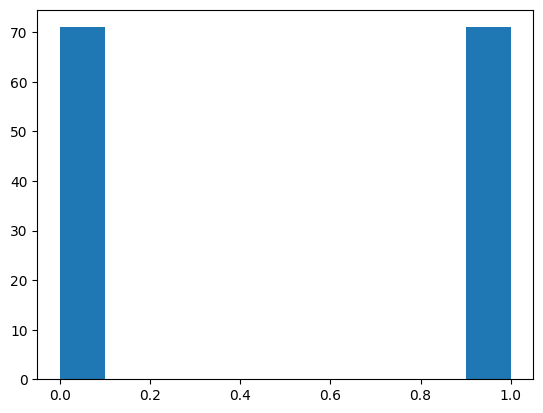

In [189]:
# Visualizing the output class balance
# Balanced 0/1 classification
plt.hist(wine_data[2])

In [30]:
ds

[['wine',
  tensor([[1.1640e+01, 2.0600e+00, 2.4600e+00,  ..., 1.0000e+00, 2.7500e+00,
           6.8000e+02],
          [1.3860e+01, 1.3500e+00, 2.2700e+00,  ..., 1.0100e+00, 3.5500e+00,
           1.0450e+03],
          [1.2340e+01, 2.4500e+00, 2.4600e+00,  ..., 8.0000e-01, 3.3800e+00,
           4.3800e+02],
          ...,
          [1.3450e+01, 3.7000e+00, 2.6000e+00,  ..., 8.5000e-01, 1.5600e+00,
           6.9500e+02],
          [1.1560e+01, 2.0500e+00, 3.2300e+00,  ..., 9.3000e-01, 3.6900e+00,
           4.6500e+02],
          [1.2820e+01, 3.3700e+00, 2.3000e+00,  ..., 7.2000e-01, 1.7500e+00,
           6.8500e+02]]),
  tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
          0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
          0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
          0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
          0., 1., 0., 1., 0., 1., 0., 1

The dataset is (($\mathbf{X}$, $\mathbf{y}$), $\mathbf{q}$)). This is fed to the model to make predictions.

In [190]:
X = wine_data[1]
rescale_features_factor = X.shape[1] / max_features if True and True else 1.0
X = torch.cat([X, torch.zeros((X.shape[0], max_features - X.shape[1]))], -1) # performing padding

#### Evaluating on just the Wine Dataset

In [207]:
result = evaluate_dataset(X, wine_data[2], [], 
                          model, bptt=seq_len, eval_position_range=eval_positions, max_samples=40, plot=False)
result # should be tuple of metric_eval_pos, outputs, eval_ys[eval_position:]

	 Eval position 30 done..


[(array([0.99591837, 0.99591837, 0.89142857, 0.94612245, 0.83836735,
         0.99510204, 0.87918367, 0.85632653, 0.90285714, 0.99591837,
         0.99755102, 0.99673469, 0.95265306, 0.89061224, 0.96734694,
         0.97877551, 0.99591837, 0.9877551 , 0.99836735, 0.97387755,
         0.89142857, 0.88      , 0.99673469, 0.92408163, 0.98285714,
         0.88      , 0.99673469, 0.95428571, 0.86938776, 0.88244898,
         0.8955102 , 0.86693878, 0.99673469, 0.94204082, 0.87183673,
         0.99755102, 0.99510204, 0.99755102, 0.99673469, 0.99591837]),
  array([[0.03147673, 0.07891157, 0.1174833 , ..., 0.05107496, 0.26766613,
          0.21977873],
         [0.75298375, 0.9558053 , 0.73578161, ..., 0.98082608, 0.97041118,
          0.95715612],
         [0.2359897 , 0.05336409, 0.12023957, ..., 0.08484938, 0.07167102,
          0.24678433],
         ...,
         [0.43739536, 0.86386549, 0.21605   , ..., 0.92208081, 0.39100716,
          0.95003033],
         [0.06253019, 0.09295728, 0.2709

In [208]:
result[0][1].shape

(70, 40)

There are 70 test points, but 40 predictions for each.

## Why? (Class Question 2) 

#
#
#
#
#
### Hint: what is the goal of this paper to obtain?
#
#
#
#
#
#
#

From the paper, the posterior for BNN is over **model architecture**. So it emulates sampling an architecture from their posterior distribution (given by the Transformer) and using that to make a point prediction. This is done 40 times. Naturally, some of these architectures will be better than others, but the posterior distribution should give good predictions on average due to the training.

**Note:** It looks like they are forming the posterior predictive distribution over model architectures, not the posterior. In theory, the posterior is captured somewhere within the Transformer, but we cannot actually access the posterior. This is a con of the approach.

In [209]:
mean_preds = [i.mean() for i in result[0][1]]

In [210]:
mean_preds

[0.4973284896928817,
 0.5066407222766429,
 0.4977026330307126,
 0.5030913200695067,
 0.5019492147956044,
 0.4890506517607719,
 0.4946201402693987,
 0.511161226965487,
 0.49690569206140933,
 0.5094255087897182,
 0.5184670626651495,
 0.5080800859257579,
 0.5069865895900876,
 0.5081100204028189,
 0.5153255650307983,
 0.5028790421783924,
 0.509566851425916,
 0.5089862764813006,
 0.509429979370907,
 0.50286196898669,
 0.5034818147774786,
 0.5039151402190327,
 0.5003199782222509,
 0.5215008819941431,
 0.5160013309214264,
 0.519038155535236,
 0.532703536376357,
 0.524162374297157,
 0.5363444237969816,
 0.533126974478364,
 0.5294537309557199,
 0.5328001832589507,
 0.5169248656369746,
 0.5188986566849053,
 0.5194560803472996,
 0.5013013345189392,
 0.5041417859494686,
 0.5086004217155278,
 0.5086468725465239,
 0.508242892054841,
 0.49038397520780563,
 0.49546381146647034,
 0.48367164875380697,
 0.4938454830087721,
 0.45315141854807733,
 0.4631079048849642,
 0.44879634864628315,
 0.44719591708853

In [211]:
test_labels = wine_data[2][30:100].detach().numpy()

### Visualizing ROC of predictions from sampled architectures for Wine Dataset

In [212]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(result[0][2].flatten(), result[0][1].flatten())
roc_auc = roc_auc_score(result[0][2].flatten(), result[0][1].flatten())

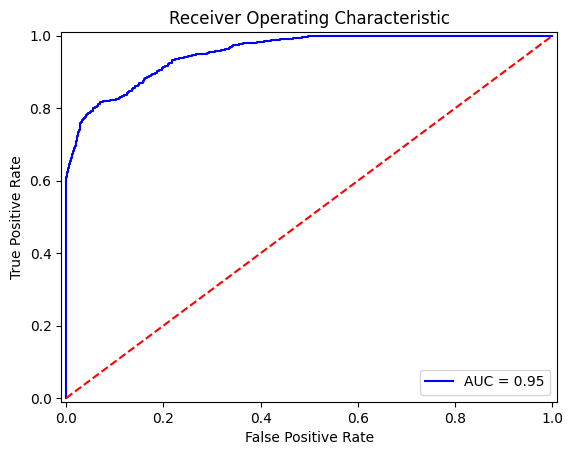

In [213]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Determine optimal threshold so we can view our predictions better

Let's say the $\text{threshold}[\arg\max_i(TPR_i - FPR_i)]$ is optimal.

This is https://en.wikipedia.org/wiki/Youden's_J_statistic

In [206]:
current_best = 0
optimal_index = 0
for i in range(len(fpr)):
    combination_metric = tpr[i] - fpr[i]
    if  combination_metric > current_best:
        current_best = combination_metric
        optimal_index = i
    
optimal_threshold = thresholds[optimal_index]
print(optimal_threshold)

0.4660896062850952


In [181]:
from sklearn.metrics import accuracy_score

accuracy_score(mean_preds>optimal_threshold, test_labels)

0.5

### Output of BNN

#### Let's consider the output for a single point

In [193]:
point_index = 5
true_label = wine_data[2][30+point_index]
point_predictions = result[0][1][5]

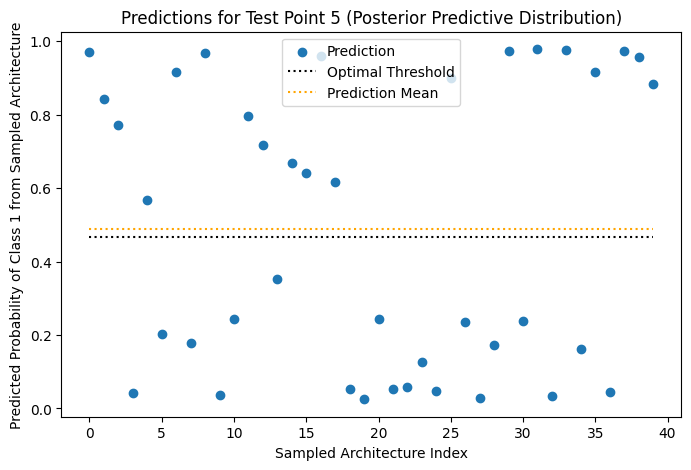

In [214]:
samples = len(point_predictions)

plt.figure(figsize=(8,5))
plt.title("Predictions for Test Point 5 (Posterior Predictive Distribution)")
plt.ylabel("Predicted Probability of Class 1 from Sampled Architecture")
plt.xlabel("Sampled Architecture Index")
plt.scatter(range(samples), point_predictions, label='Prediction')
plt.plot(range(samples), np.repeat(optimal_threshold, samples), ':', color='black', label='Optimal Threshold')
plt.plot(range(samples), np.repeat(point_predictions.mean(), samples), ':', color='orange', label='Prediction Mean')
plt.legend()